In [2]:
from __future__ import print_function, division

%matplotlib inline

import thinkdsp
import thinkplot
import numpy as np
import math

import warnings
warnings.filterwarnings('ignore')

from IPython.html.widgets import interact, interact_manual, fixed
from IPython.html import widgets
from IPython.display import display

PI2 = 2 * math.pi

# Exercise
鋸齒信號的波形從-1線性上升到1，然後下降到-1並重複。 參見http://en.wikipedia.org/wiki/Sawtooth_wave

編寫一個名為SawtoothSignal的類，該類擴展Signal並提供provides以評估鋸齒信號。

計算鋸齒波的頻譜。 諧波結構與三角波和方波相比如何？

# Solution
我的解決方案基本上是TriangleSignal的簡化版本。

In [3]:
class SawtoothSignal(thinkdsp.Sinusoid):
    """Represents a sawtooth signal."""
    
    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        ts: float array of times
        
        returns: float wave array
        """
        cycles = self.freq * ts + self.offset / PI2
        frac, _ = np.modf(cycles)
        ys = thinkdsp.normalize(thinkdsp.unbias(frac), self.amp)
        return ys

聲音如下:

In [4]:
sawtooth = SawtoothSignal().make_wave(duration=0.5, framerate=40000)
sawtooth.make_audio()

spectrum:

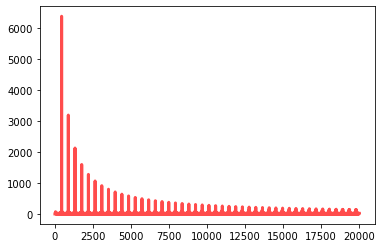

In [5]:
sawtooth.make_spectrum().plot(color='red')

與方波相比，鋸齒波下降得類似，但是它包括偶數和奇數諧波。 請注意，我必須削減方波的幅度以使其具有可比性。

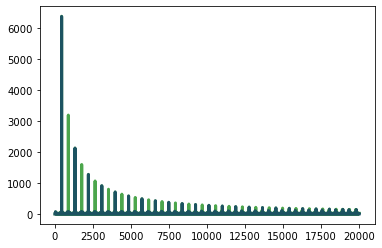

In [6]:
sawtooth.make_spectrum().plot(color='green')
square = thinkdsp.SquareSignal(amp=0.5).make_wave(duration=0.5, framerate=40000)
square.make_spectrum().plot()

與三角波相比，鋸齒的下降速度不那麼快。

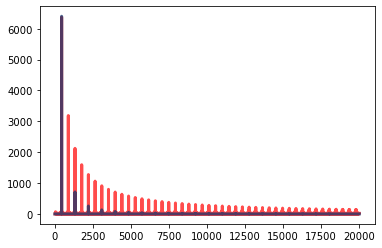

In [7]:
sawtooth.make_spectrum().plot(color='red')
triangle = thinkdsp.TriangleSignal(amp=0.79).make_wave(duration=0.5, framerate=40000)
triangle.make_spectrum().plot()

具體來說，三角波的諧波按1/𝑓2的比例下降，而鋸齒像1/𝑓那樣下降。

# Exercise
發出1100 Hz的方波，並產生以每秒10000幀的速度對其採樣的波形。 如果繪製頻譜圖，則可以看到大多數諧波都是混疊的。 當您聽波時，您能聽到混疊諧波嗎？

# Solutiun
方波

In [8]:
square = thinkdsp.SquareSignal(1100).make_wave(duration=0.5, framerate=10000)

spectrum

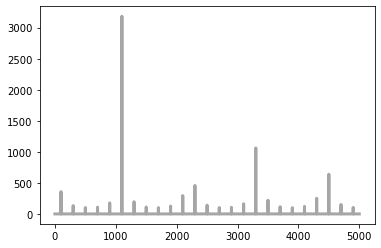

In [9]:
square.make_spectrum().plot(color='gray')

在1100 Hz處產生方波並產生波形基波和第一諧波在正確的位置，但是第二次諧波（應為5500 Hz）被別名為4500 Hz。 第三個應該是7700 Hz，別名是2300 Hz，依此類推。

聆聽聲波時，您會以低音聽到這些混疊諧波。

In [10]:
square.make_audio()

我最明顯聽到的聲音是300 Hz。

In [11]:
thinkdsp.SinSignal(300).make_wave(duration=0.5, framerate=10000).make_audio()

# Exercise
如果您有一個光譜對象，一個光譜並打印了Spectrum.fs的前幾個值，您會發現它們從零開始。 因此，spectrum.hs[0]是頻率為0的分量的幅度。但這意味著什麼？

試試這個實驗：
1. 製作一個頻率為440的三角形信號，並製作一個持續時間為0.01秒的Wave。 繪製波形圖。
2. 創建一個Spectrum對象並打印Spectrum.hs[0]。 該分量的幅度和相位是多少？
3. 設置Spectrum.hs[0] =100。從修改後的Spectrum生成一個Wave並將其繪製。 此操作對波形有什麼影響？

# Solution
三角波:

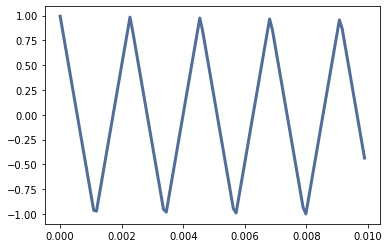

In [12]:
triangle = thinkdsp.TriangleSignal().make_wave(duration=0.01)
triangle.plot()

頻譜的第一個元素是接近零的複數。

In [13]:
spectrum = triangle.make_spectrum()
spectrum.hs[0]

(1.0436096431476471e-14+0j)

如果我們添加零頻率分量，則具有增加波的垂直偏移的效果。

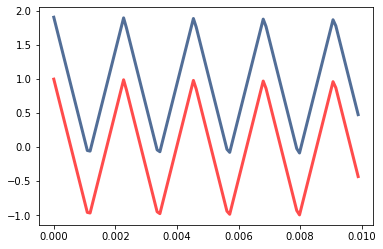

In [14]:
spectrum.hs[0] = 100
triangle.plot(color='red')
spectrum.make_wave().plot()

零頻分量是信號中所有值的總和，這將在我們深入探討DFT的細節時看到。 如果信號無偏，則零頻分量為0。在電信號的上下文中，零頻項稱為DC偏移；對於零頻項，稱為DC偏移。 即，將直流偏移添加到交流信號。

# Exercise
編寫一個函數，將頻譜作為參數，並通過將hs的每個元素除以fs的相應頻率來對其進行修改。 使用存儲庫中的WAV文件之一或任何Wave對象測試您的功能。

1. 計算頻譜並繪製。
2. 使用您的函數修改頻譜並再次繪製。
3. 從修改後的頻譜中創建一個波形並聆聽。 此操作對信號有什麼影響？

# Solution
以下是編寫的函數

In [15]:
def filter_spectrum(spectrum):
    spectrum.hs /= spectrum.fs
    spectrum.hs[0] = 0

三角波:

In [16]:
wave = thinkdsp.TriangleSignal(freq=440).make_wave(duration=0.5)
wave.make_audio()

這是前後的樣子。 我按比例縮放後的圖片，使其以相同的比例可見。

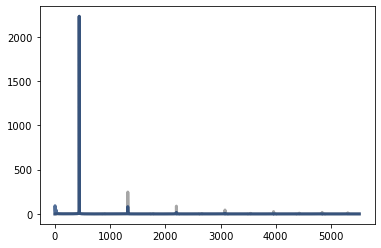

In [17]:
high = 10000
spectrum = wave.make_spectrum()
spectrum.plot(high=high, color='gray')
filter_spectrum(spectrum)
spectrum.scale(440)
spectrum.plot(high=high)

該濾波器會濾除諧波，因此其作用類似於低通濾波器。

聽起來是這樣的：

In [18]:
filtered = spectrum.make_wave()
filtered.make_audio()

現在，三角波聽起來幾乎像是正弦波。

# Exercise
三角波和方波僅具有奇次諧波； 鋸齒波同時具有偶次和奇次諧波。 方波和鋸齒波的諧波下降與1/f成正比; 三角波的諧波像1/f2一樣下降。 您能找到具有偶次和奇次諧波下降的波形，例如1/f2嗎？

提示：有兩種方法可以解決此問題：可以通過添加正弦波來構造所需的信號，或者可以從與所需信號相似的信號開始並進行修改。

# Solution
一種選擇是從鋸齒波開始，該鋸齒波具有我們需要的所有諧波：

In [19]:
freq = 500
signal = thinkdsp.SawtoothSignal(freq=freq)
wave = signal.make_wave(duration=0.5, framerate=20000)
wave.make_audio()

spectrum(諧波像1 /𝑓一樣下降。)

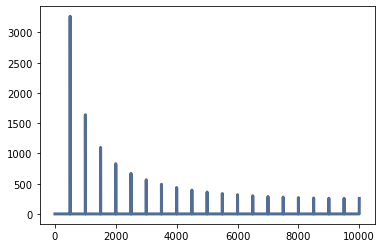

In [20]:
spectrum = wave.make_spectrum()
spectrum.plot()

如果應用在上一個練習中編寫的濾波器，我們可以使諧波像1 /𝑓2一樣下降。

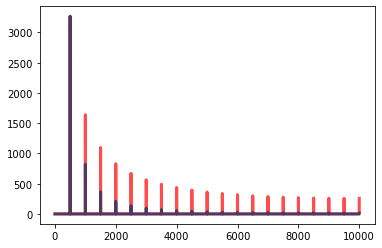

In [21]:
spectrum.plot(color='red')
filter_spectrum(spectrum)
spectrum.scale(freq)
spectrum.plot()

聲音聽起來如下:

In [22]:
wave = spectrum.make_wave()
wave.make_audio()

波型圖如下:

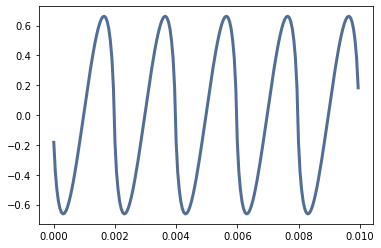

In [23]:
wave.segment(duration=0.01).plot()

這是一個有趣的形狀，但不容易看出它的功能形式是什麼。

另一種方法是將頻率和幅度正確的一系列餘弦信號相加。

In [24]:
freqs = np.arange(500, 9500, 500)
amps = 1 / freqs**2
signal = sum(thinkdsp.CosSignal(freq, amp) for freq, amp in zip(freqs, amps))
signal

spectrum:

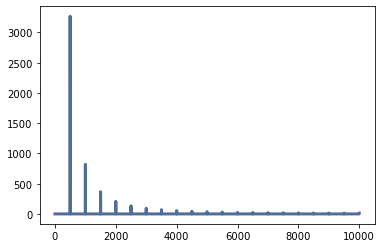

In [25]:
spectrum = wave.make_spectrum()
spectrum.plot()

聲音如下:

In [26]:
wave = signal.make_wave(duration=0.5, framerate=20000)
wave.make_audio()

波型圖:

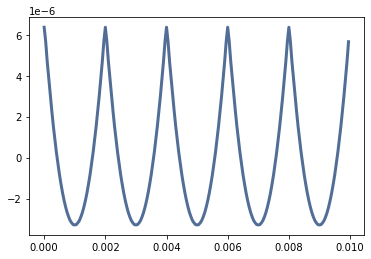

In [27]:
wave.segment(duration=0.01).plot()

如果那些看起來像拋物線，那麼您可能是對的。 thinkdsp提供了ParabolicSignal，用於計算拋物線波形。

In [28]:
wave = thinkdsp.ParabolicSignal(freq=500).make_wave(duration=0.5, framerate=20000)
wave.make_audio()

波形圖

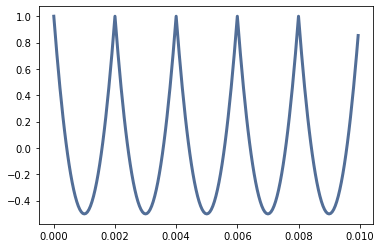

In [29]:
wave.segment(duration=0.01).plot()

拋物線信號具有偶次和奇次諧波，它們像1/𝑓2一樣下降：

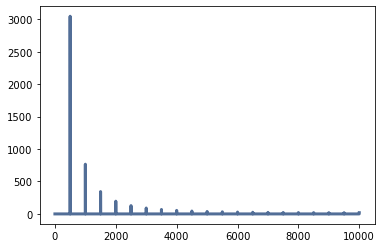

In [30]:
spectrum = wave.make_spectrum()
spectrum.plot()